In [306]:
import cooperpairbox as cpb
import SingleQubitLoss as sql
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import lmfit as lm

In [277]:
# Constants
h = 6.626e-34
hbar = h/(2*np.pi)
kb = 1.380649e-23
e_charge = 1.602e-19
Rk = h/e_charge**2

def pair_max(x):
    x1 = x[:-1]
    x2 = x[1:]
    return np.maximum(x1,x2)


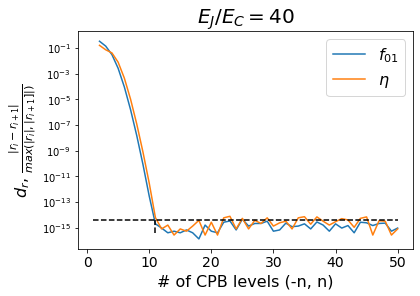

In [278]:
# Test the convergence of frequency and anharmonicity as a function of the numbers of levels
nlevels = range(1,51)
CPB = cpb.Hcpb()

EjEc = 40
Ec = 0.2
Ej = EjEc*Ec

CPB.Ec = Ec
CPB.Ej = Ej

f01_list = []
eta_list = []



for lev in nlevels:
    CPB.nlevels = lev
    f01_list.append(CPB.fij(0,1))
    eta_list.append(CPB.anharm())

f01_list = np.array(f01_list)
eta_list = np.array(eta_list)


df01 = np.diff(f01_list)
deta = np.diff(eta_list)

max_df01 = pair_max(f01_list)
max_deta = pair_max(f01_list)






plt.plot(nlevels[1:], np.abs(df01)/max_df01, label=r'$f_{01}$')
plt.plot(nlevels[1:], np.abs(deta)/max_deta, label=r'$\eta$')
plt.ylabel(r'$d_r$, $\frac{|r_i - r_{i+1}|}{max(|r_i|,|r_{i+1}]|)}$',
           fontsize=16)
plt.xlabel(r'# of CPB levels (-n, n)', fontsize=16)
plt.title(r'$E_J/E_C=40$', fontsize=20)
plt.xticks(size=14)

plt.legend(fontsize=16)
plt.plot([1, 50], [4e-15]*2, '--k')
plt.plot([11]*2, [0.4e-15, 4e-15], '--k')

plt.yscale('log')


In [279]:
EjEc = np.linspace(0.1, 500.1, 501)
CPB = cpb.Hcpb()
nlevels = range(1,51)

Ec = 0.2

f01_list = []
eta_list = []

CPB.Ec = Ec
for i, ejec in enumerate(EjEc):
    Ej = Ec*ejec
    CPB.Ej = Ej
    f01_temp = []
    eta_temp = []
    for level in nlevels:
        CPB.nlevels = level
        f01_temp.append(CPB.fij(0,1))
        eta_temp.append(CPB.anharm())
    f01_list.append(f01_temp)
    eta_list.append(eta_temp)
    # print(i)
     
    

In [280]:
# Find how many levels are required to converge as a function of Ej/Ec ratio
f01_list = np.array(f01_list)
eta_list = np.array(eta_list)


n_f01 = []
n_eta = []

for i in range(501):
    df01 = np.diff(f01_list[i, :])
    deta = np.diff(eta_list[i, :])

    max_df01 = pair_max(f01_list[i, :])
    max_deta = pair_max(f01_list[i, :])

    rel_f01 = np.abs(df01)/max_df01
    rel_eta = np.abs(deta)/max_deta

    n_f01.append(np.argmax(rel_f01<0.5e-14))
    n_eta.append(np.argmax(rel_f01<0.5e-14))

n_f01 = np.array(n_f01)
n_eta = np.array(n_eta)

[[Model]]
    Model(fit_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 501
    # variables        = 2
    chi-square         = 43.1230018
    reduced chi-square = 0.08641884
    Akaike info crit   = -1224.72733
    Bayesian info crit = -1216.29412
[[Variables]]
    a:  3.52772585 +/- 0.01688069 (0.48%) (init = 1)
    p:  0.25 (fixed)
    c:  2.31499420 +/- 0.06516954 (2.82%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, c) = -0.979


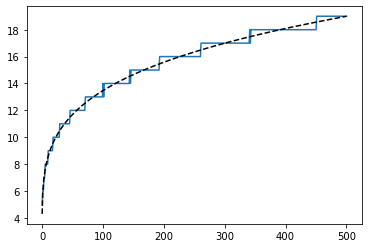

In [281]:

plt.plot(EjEc, n_f01+2)
# plt.plot(EjEc, n_eta+2)
# plt.plot([40]*2, [4,11], '--k')
# plt.xscale('log')
# plt.plot(EjEc, np.sqrt(EjEc), '--k')
def fit_model(x, a, p, c):
    return a*x**p + c

model = lm.Model(fit_model)
params = model.make_params(a=1, p=0.25, c=5)
params['p'].vary=False
result = model.fit(n_f01+2, params, x=EjEc)
print(result.fit_report())
plt.plot(EjEc, result.best_fit, '--k')
#Empirically 

(4, 501, 5)
(4, 501, 5)


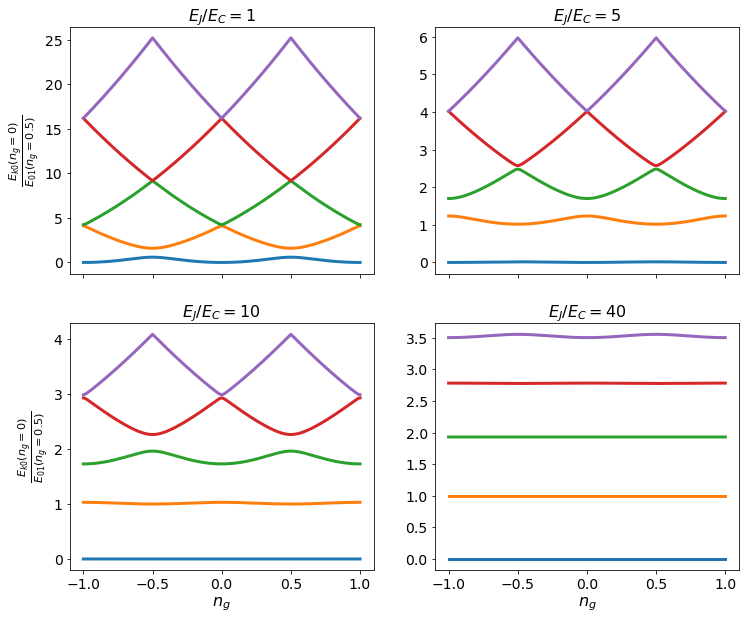

In [282]:
ng_list = np.linspace(-1, 1, 501)
EjEc_list = np.array([1, 5, 10, 40])

Ec = 0.2
n_levels = np.round(3.52772585*(EjEc_list)**0.25+2.315)
CPB = cpb.Hcpb()

evals = []

k = 5

for ejec, n_lev in zip(EjEc_list, n_levels):
    Ej = ejec*Ec
    CPB.nlevels = int(n_lev)
    CPB.Ec = Ec
    CPB.Ej = Ej
    eval_temp = []
    for ng in ng_list:
        CPB.ng = ng
        eval_temp.append(CPB.evals[:k])
    evals.append(eval_temp)

evals = np.array(evals)
print(evals.shape)

evals_gnd = np.tile(evals[:, len(ng_list)//2, 0], (5, 501, 1))
evals_gnd = np.swapaxes(evals_gnd, 0, 2)
# evals_gnd = np.swapaxes(evals_gnd, 1, 2)
evals_new = evals - evals_gnd
print(evals_new.shape)
evals_f01 = np.tile(evals[:, len(ng_list)//4, 1], (5, 501, 1)) - np.tile(evals[:, len(ng_list)//4, 0], (5, 501, 1))
evals_f01 = np.swapaxes(evals_f01, 0, 2)
evals_new = evals_new/evals_f01

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 10))

for i in range(2):
    for j in range(2):
        ax[i, j].plot(ng_list, 
                      evals_new[int('{}{}'.format(i,j),2), :, :],
                      lw=3)
        ax[i, j].set_title(r'$E_J/E_C={}$'.format(EjEc_list[int('{}{}'.format(i,j),2)]),
                           fontsize=16)
        ax[i, j].tick_params(labelsize=14)
_ = ax[0,0].set_ylabel(r'$\frac{E_{k0}(n_g=0)}{E_{01}(n_g=0.5)}$', fontsize=16)
_ = ax[1,0].set_ylabel(r'$\frac{E_{k0}(n_g=0)}{E_{01}(n_g=0.5)}$', fontsize=16)
_ = ax[1,0].set_xlabel(r'$n_g$', fontsize=16)
_ = ax[1,1].set_xlabel(r'$n_g$', fontsize=16) 

In [283]:
EjEc = np.linspace(0.5, 500.5, 50001)
CPB = cpb.Hcpb(nlevels=30)
Ec = 0.2
CPB.Ec = Ec

f01_list = []
eta_list = []
for ejec in EjEc:
    Ej = Ec*ejec
    CPB.Ej = Ej
    f01_list.append(CPB.fij(0,1))
    eta_list.append(CPB.anharm())

f01_list = np.array(f01_list)
eta_list = np.array(eta_list)

In [284]:
model = lm.Model(fit_model)
params = model.make_params(a=-1, p=-0.5, c=-1)
params['p'].vary=True
result = model.fit(eta_list[4000:]/Ec, params, x=EjEc[4000:])
print(result.fit_report())

[[Model]]
    Model(fit_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 46001
    # variables        = 3
    chi-square         = 0.00134912
    reduced chi-square = 2.9330e-08
    Akaike info crit   = -797868.354
    Bayesian info crit = -797842.145
[[Variables]]
    a: -1.97262806 +/- 5.7475e-04 (0.03%) (init = -1)
    p: -0.68061445 +/- 8.5005e-05 (0.01%) (init = -0.5)
    c: -1.00991353 +/- 8.0573e-06 (0.00%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, p) =  0.995
    C(p, c) =  0.976
    C(a, c) =  0.952


In [293]:
model = lm.Model(fit_model)
params = model.make_params(a=1, p=0.5, c=1)
params['p'].vary=True
result = model.fit(f01_list[3000:]/Ec, params, x=EjEc[3000:])
print(result.fit_report())

[[Model]]
    Model(fit_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 47001
    # variables        = 3
    chi-square         = 0.09014646
    reduced chi-square = 1.9181e-06
    Akaike info crit   = -618726.622
    Bayesian info crit = -618700.348
[[Variables]]
    a:  2.85408555 +/- 3.2113e-05 (0.00%) (init = 1)
    p:  0.49888522 +/- 1.5372e-06 (0.00%) (init = 0.5)
    c: -1.15156218 +/- 1.1960e-04 (0.01%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, p) = -0.999
    C(a, c) = -0.989
    C(p, c) =  0.982


(-2, 1)

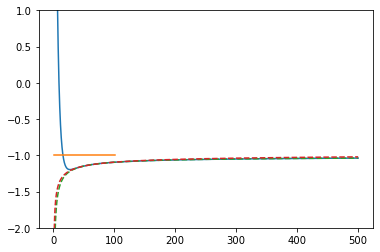

In [286]:
plt.plot(EjEc, eta_list/Ec)
plt.plot([0.5, 100.5], [-1]*2 )
# plt.plot(EjEc, ((np.sqrt(8*EjEc*Ec*Ec)-Ec)*(8*EjEc)**(-0.45)-2.45*Ec)/Ec, '--k')
plt.plot(EjEc, -2.06300306*(EjEc)**(-0.69250170)-1.01036736, '--')
plt.plot(EjEc, -1.19844418*(EjEc)**(-0.46935793)-0.95659319, '--')
plt.ylim([-2, 1])

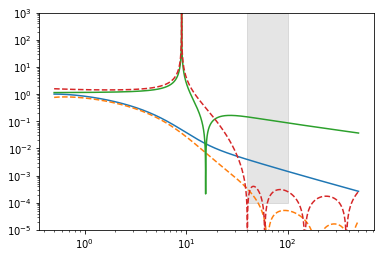

In [295]:
# how much trouble do the approximations get you into
# empirically better power law scaling for design rules
f01_approx = np.sqrt(8*EjEc*Ec*Ec)-Ec
f01_approx_better = (2.85111969*(EjEc)**(0.49902335)-1.13952037)*Ec
eta_approx = -Ec
# eta_approx_better = (np.sqrt(8*EjEc*Ec*Ec)-Ec)*(8*EjEc)**(-0.45)-2.45*Ec
eta_approx_better = (-1.97262806*(EjEc)**(-0.68061445)-1.00991353)*Ec

plt.plot(EjEc, np.abs(1-f01_approx/f01_list))
plt.plot(EjEc, np.abs(1-f01_approx_better/f01_list), '--')
plt.plot(EjEc, np.abs(1-eta_approx/eta_list))
plt.plot(EjEc, np.abs(1-eta_approx_better/eta_list), '--')
# plt.plot(EjEc, np.abs(eta_list-eta_approx_better)/np.abs(eta_list), '--')
# print(np.sqrt(8*60*0.20*0.20)-0.20)
# plt.plot(EjEc, np.abs(f01_approx))
plt.xscale('log')
plt.yscale('log')
# plt.plot(EjEc, f01_approx, '--')
plt.fill_between([40, 100], 1e-4, 1e3, color='k', alpha=0.1)
# plt.xlim([5e-1, 1e2])
plt.ylim([1e-5, 1e3])
plt.show()



In [404]:
# ZPF calculations as a function of EjEc
from matplotlib.rcsetup import validate_int_or_None

nlevel = 50
Ec = 0.2
EjEc = 40
ng = 0.5
CPB = cpb.Hcpb(ng=ng)

CPB.Ec = Ec
CPB.Ej = EjEc*Ec
CPB.nlevels = nlevel


EjEc = np.linspace(1, 501, 1001)


k = 14
phi = np.linspace(-np.pi, np.pi, 2**k+1)
n_op = np.diag(CPB._diag)

n_ZPF_list = []
phi_ZPF_list = []

for ejec in EjEc:
    CPB.Ej = ejec*Ec
    n_0 = CPB.evec_k(0)
    psi0 = CPB.psi_k(0, pts=2**k+1)

    n_ZPF = n_0.T@n_op**2@n_0
    n_avg = (n_0.T@n_op@n_0)**2

    y1 = np.abs(psi0.conj()*psi0)*phi**2
    y2 = np.abs(psi0.conj()*psi0)*phi
    phi_ZPF = integrate.romb(y1, dx=np.diff(phi)[0])
    phi_avg = integrate.romb(y2, dx=np.diff(phi)[0])**2

    n_ZPF_list.append(np.sqrt(n_ZPF-n_avg))
    phi_ZPF_list.append(np.sqrt(phi_ZPF-phi_avg))



n_ZPF_list = np.array(n_ZPF_list)
phi_ZPF_list = np.array(phi_ZPF_list)





# y = phi**2*psi0.conj()*psi0



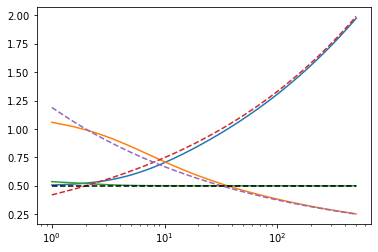

In [407]:
# Notice the breakdown at low EjEc ratio
# This is due to the breakdown of the tight-binding model
# where phi can no longer be represented as a compact variable over [-pi, pi]

plt.plot(EjEc, n_ZPF_list)
plt.plot(EjEc, phi_ZPF_list)
plt.plot(EjEc, n_ZPF_list*phi_ZPF_list)
plt.plot(EjEc, (EjEc/32)**0.25, '--')
plt.plot(EjEc, (2/EjEc)**0.25, '--')
plt.plot(EjEc, (2/EjEc)**0.25*(EjEc/32)**0.25, '--k')
plt.xscale('log')

In [289]:
Dng_phi = 2*(h*CPB.Ec*1e9)*(CPB.n_ij(0,0) - CPB.n_ij(1,1))/hbar
Dng_T = 4*(h*CPB.Ec*1e9)*CPB.n_ij(0,1)/hbar
# Dphi_T = 0.5*CPB.Ej




S_vg = lambda omega, T, Z: (hbar*omega/(2*np.pi))*(1/np.tanh(hbar*omega/(2*kb*T)) + 1)*np.real(Z(omega))
Z_omega = lambda omega: 50

# print(sql.Gamma_rel(2*np.pi*CPB.fij(0,1)*1e9, Dng_T, S_vg, (0.05, Z_omega)))
# print(16*np.pi*((0.05e-15/(100e-15 + 0.05e-15))**2)*(2*np.pi*1e9*CPB.fij(0,1))*50/(Rk)*CPB.n_ij(0,1)**2)

In [290]:
# gamma = 16*np.pi*((0.05/(100 + 0.05))**2)*(h*1e9*CPB.fij(0,1))*50/(Rk)*CPB.n_ij(0,1)**2
Qd = 100e-15/((2*np.pi*5e9)*50*(50e-18)**2)
T1 = Qd/(2*np.pi*5e9)
print(T1/1e-6)

810.5694691387024
